In [1]:
# here we create the back test with x & y, cell id: 6
# Important, here we assume data is clean and equal in length
# Also the sharpe is daily
import pandas as pd
import numpy as np

def calculate_sharpe_ratio(returns, risk_free_rate=0):

    returns = returns/100
    excess_returns = returns - risk_free_rate
    return (excess_returns.mean() / excess_returns.std())


def create_backtest(df_binance, df_upbit, data_fraction_for_test=2, x_threshold=1, y_threshold=-1, print_log=False):
    """
    Create backtest based on the strategy:
    - Long Bitcoin on Binance when Bitcoin goes up X% on Upbit
    - Short Bitcoin on Binance when Bitcoin goes down Y% on Upbit
    """
    try:
        
        split_date = df_binance.iloc[len(df_binance)//data_fraction_for_test]['date']
        start_date_backtest = df_binance['date'].min().strftime('%Y-%m-%d')

        df_binance_back = df_binance[df_binance['date'] < split_date].copy()
        df_upbit_back = df_upbit[df_upbit['date'] < split_date].copy()
        
        df_binance_back['position'] = 0  
        
        for i in range(1, len(df_upbit_back)):
            upbit_pnl = df_upbit_back.iloc[i]['p_n_l']
            
            if upbit_pnl >= x_threshold:
                df_binance_back.iloc[i, df_binance_back.columns.get_loc('position')] = 1
            elif upbit_pnl <= y_threshold:
                df_binance_back.iloc[i, df_binance_back.columns.get_loc('position')] = -1

        df_binance_back['strategy_returns'] = df_binance_back['position'].shift(1) * df_binance_back['p_n_l']
        df_binance_back['cumulative_returns'] = (1 + df_binance_back['strategy_returns']/100).cumprod()


        sharpe = calculate_sharpe_ratio(df_binance_back['strategy_returns'].dropna())
        if print_log:
            print(f"Data range is {start_date_backtest} -> {split_date.strftime('%Y-%m-%d')}")
            print(f"Cumulative Return for X:{x_threshold} & Y:{y_threshold} is {round((df_binance_back['cumulative_returns'].iloc[-1] - 1) * 100, 2)}% with sharpe ratio: {round(sharpe,3)}")
        
        return sharpe
        
    except Exception as e:
        print(f"Error: {e}")
        return None


file1 = "./binance_data/usdt_btc.csv"
file2 = "./upbit_data/usdt_btc.csv"

df_binance = pd.read_csv(file1)
df_upbit = pd.read_csv(file2)

df_binance['date'] = pd.to_datetime(df_binance['date'])
df_upbit['date'] = pd.to_datetime(df_upbit['date'])

df_binance = df_binance.sort_values('date')
df_upbit = df_upbit.sort_values('date')

backtest_results = create_backtest(
    df_binance=df_binance,
    df_upbit=df_upbit,
    data_fraction_for_test=2,  # 2 here is mean 1/2 of the data
    x_threshold=1.3,
    y_threshold=-2,
    print_log=True
)


Data range is 2022-09-13 -> 2023-10-18
Cumulative Return for X:1.3 & Y:-2 is 29.11% with sharpe ratio: 0.045




Best combination: X=0.0, Y=-0.1, Sharpe=0.05


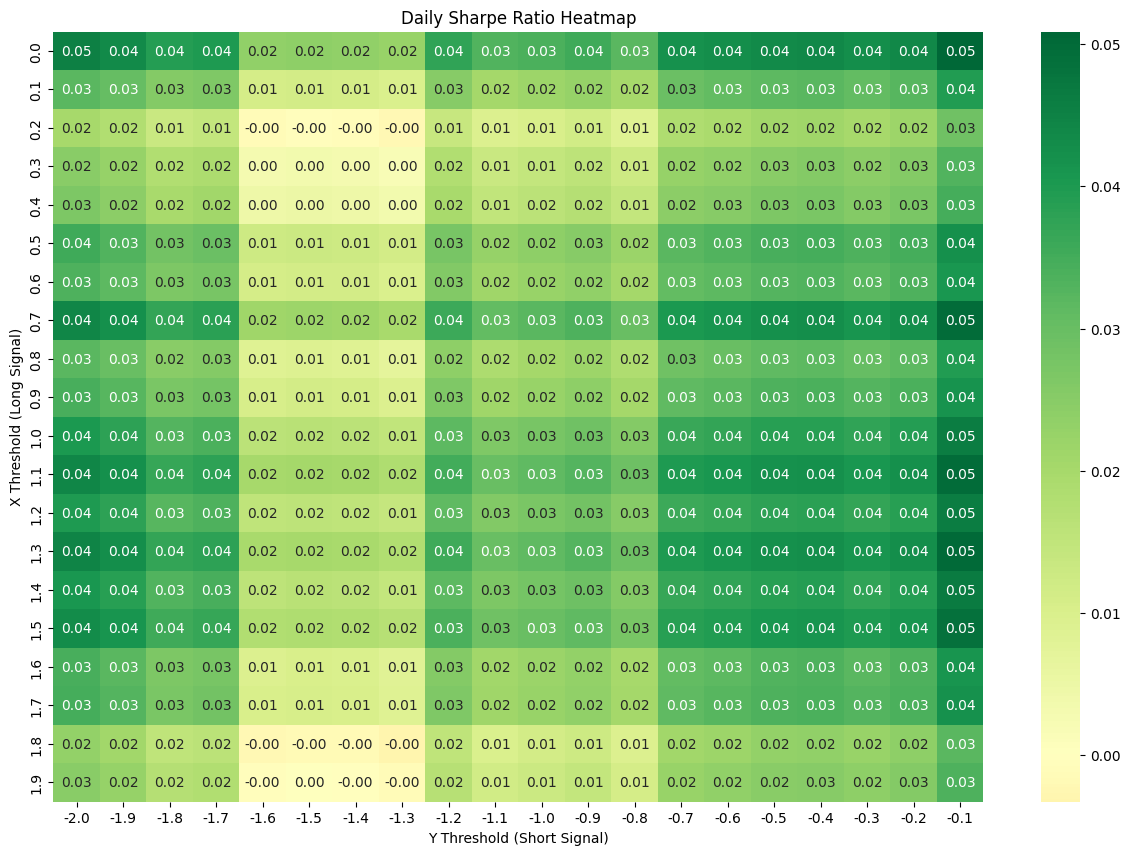

In [2]:
# here we generate the sharpe ratio heat map, cell id: 7

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def generate_sharpe_heatmap(df_binance, df_upbit, 
                           x_range=np.arange(0, 2, 0.1), 
                           y_range=np.arange(-2.0, 0, 0.1), show_graph=False):

    results = []
    
    for x in x_range:
        row = []
        for y in y_range:
            sharpe = create_backtest(
                df_binance=df_binance,
                df_upbit=df_upbit,
                x_threshold=x,
                y_threshold=y
            )
            row.append(sharpe)
        results.append(row)
    

    
    # Find best combination
    results_array = np.array(results)
    max_idx = np.unravel_index(results_array.argmax(), results_array.shape)
    best_x = x_range[max_idx[0]]
    best_y = y_range[max_idx[1]]
    best_sharpe = results_array[max_idx]
    
    if show_graph == True:
        plt.figure(figsize=(15, 10))
        sns.heatmap(results, 
        xticklabels=[f'{y:.1f}' for y in y_range],
        yticklabels=[f'{x:.1f}' for x in x_range],
        cmap='RdYlGn',
        center=0,
        annot=True,
        fmt='.2f')

        plt.title('Daily Sharpe Ratio Heatmap')
        plt.xlabel('Y Threshold (Short Signal)')
        plt.ylabel('X Threshold (Long Signal)')
        print(f"\n\nBest combination: X={best_x:.1f}, Y={best_y:.1f}, Sharpe={best_sharpe:.2f}")
        plt.show()
    
    return best_x, best_y, best_sharpe



file1 = "./binance_data/usdt_btc.csv"
file2 = "./upbit_data/usdt_btc.csv"

df_binance = pd.read_csv(file1)
df_upbit = pd.read_csv(file2)

df_binance['date'] = pd.to_datetime(df_binance['date'])
df_upbit['date'] = pd.to_datetime(df_upbit['date'])

df_binance = df_binance.sort_values('date')
df_upbit = df_upbit.sort_values('date')

heatmap = generate_sharpe_heatmap(df_binance, df_upbit, show_graph=True)

Maximum Drawdown: 44.23%
Peak Index: 26, Peak Value: 1.2626, date: 2023-11-14
Trough Index: 88, Trough Value: 0.7042, date: 2024-01-15
Data range is 2023-10-18 -> 2024-11-19
Cumulative Return for X: 0.0 & Y: -0.1 is 17.27% with daily sharpe ratio: 0.028, max_drawdown: 44.231 %, CAGR: 15.734 %


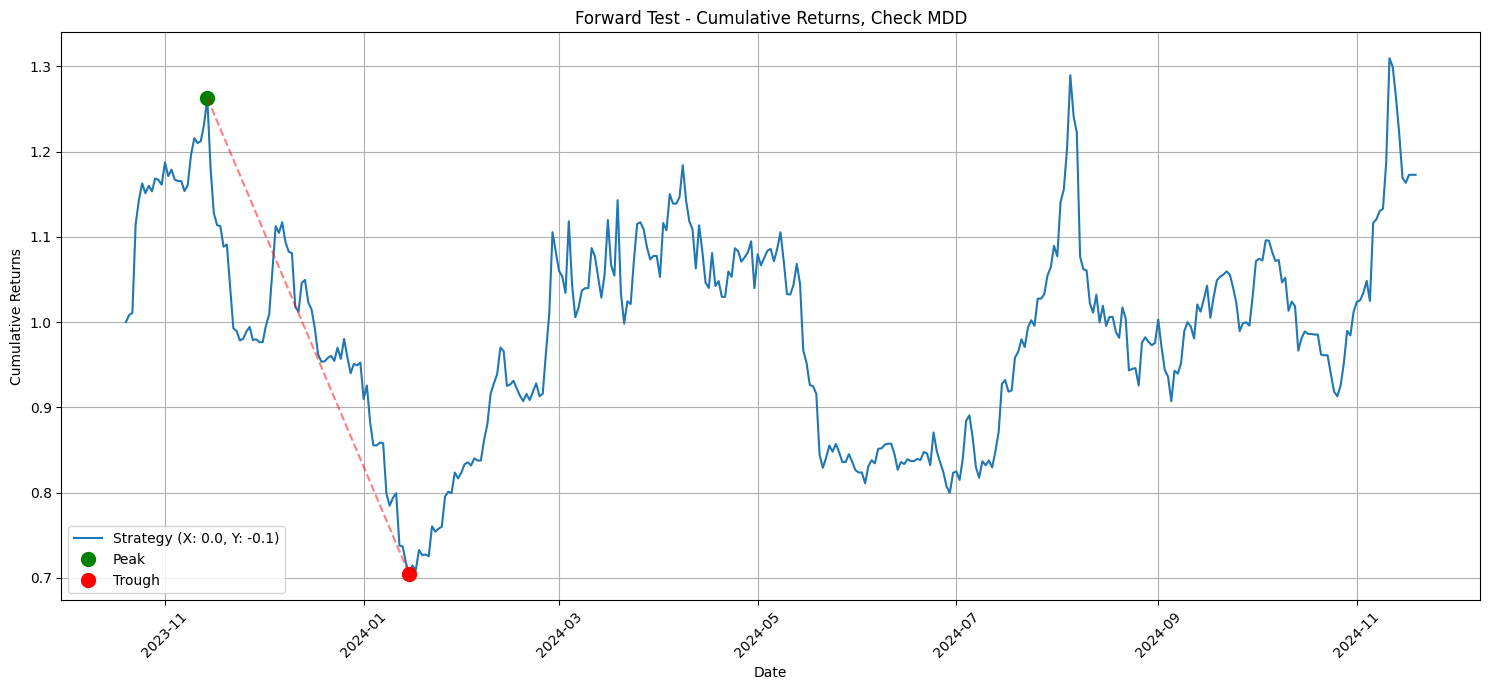

In [3]:
# here we create the forward test with x & y calculated with heatmap sharpe test, cell id: 8
import pandas as pd

def calculate_max_drawdown(cumulative_returns_input, dates):
    cumulative_returns = cumulative_returns_input.copy().sort_index(ascending=False).reset_index(drop=True)
    max_drawdown = float('-inf') 
    peak_idx = 0
    trough_idx = 0

    for i in range(len(cumulative_returns)):
        peak = cumulative_returns[i]
        for j in range(i + 1, len(cumulative_returns)):
            trough= cumulative_returns[j]
            drawdown = (peak-trough)/peak
            if drawdown > max_drawdown:
                max_drawdown = drawdown
                peak_idx = i
                trough_idx = j
    
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    print(f"Peak Index: {peak_idx}, Peak Value: {cumulative_returns[peak_idx]:.4f}, date: {dates.iloc[peak_idx].strftime('%Y-%m-%d')}")
    print(f"Trough Index: {trough_idx}, Trough Value: {cumulative_returns[trough_idx]:.4f}, date: {dates.iloc[trough_idx].strftime('%Y-%m-%d')}")
    
    return max_drawdown, peak_idx, trough_idx

def calculate_cagr(final_value, initial_value, n_days):
    years = n_days / 365
    return (pow(final_value / initial_value, 1 / years) - 1) * 100

def create_forward(df_binance, df_upbit, data_fraction_for_test=2, x_threshold=1, y_threshold=-1):
    """
    Create backtest based on the strategy:
    - Long Bitcoin on Binance when Bitcoin goes up X% on Upbit
    - Short Bitcoin on Binance when Bitcoin goes down Y% on Upbit
    """
    try:
        
        split_date = df_binance.iloc[len(df_binance)//data_fraction_for_test]['date']
        end_date_forwardtest = df_binance['date'].max().strftime('%Y-%m-%d')

        df_binance_forward = df_binance[df_binance['date'] > split_date].copy()
        df_upbit_forward = df_upbit[df_upbit['date'] > split_date].copy()
        
        df_binance_forward['position'] = 0  
        
        for i in range(1, len(df_upbit_forward)):
            upbit_pnl = df_upbit_forward.iloc[i]['p_n_l']
            
            if upbit_pnl >= x_threshold:
                df_binance_forward.iloc[i, df_binance_forward.columns.get_loc('position')] = 1
            elif upbit_pnl <= y_threshold:
                df_binance_forward.iloc[i, df_binance_forward.columns.get_loc('position')] = -1

        df_binance_forward['strategy_returns'] = df_binance_forward['position'].shift(1) * df_binance_forward['p_n_l']
        df_binance_forward['cumulative_returns'] = (1 + df_binance_forward['strategy_returns']/100).cumprod()


        sharpe = calculate_sharpe_ratio(df_binance_forward['strategy_returns'].dropna())
        max_drawdown, peak_idx, trough_idx = calculate_max_drawdown(df_binance_forward['cumulative_returns'], df_binance_forward['date'])
        n_days = len(df_binance_forward) + 1
        cagr = calculate_cagr(
        df_binance_forward['cumulative_returns'].iloc[-1],
        1,
        n_days
        )
        print(f"Data range is {split_date.strftime('%Y-%m-%d')} -> {end_date_forwardtest}")

        print(f"Cumulative Return for X: {round(x_threshold,3)} & Y: {round(y_threshold,3)} is {round((df_binance_forward['cumulative_returns'].iloc[-1] - 1) * 100, 2)}% with daily sharpe ratio: {round(sharpe,3)}, max_drawdown: {round(max_drawdown * 100,3)} %, CAGR: {round(cagr,3)} %")
        
        plt.figure(figsize=(15, 7))
        
        plt.plot(df_binance_forward['date'], df_binance_forward['cumulative_returns'], 
                label=f'Strategy (X: {round(x_threshold,3)}, Y: {round(y_threshold,3)})')

        plt.plot(df_binance_forward['date'].iloc[peak_idx], 
                df_binance_forward['cumulative_returns'].iloc[peak_idx], 
                'go', markersize=10, label='Peak')
        plt.plot(df_binance_forward['date'].iloc[trough_idx], 
                df_binance_forward['cumulative_returns'].iloc[trough_idx], 
                'ro', markersize=10, label='Trough')
        
        plt.plot([df_binance_forward['date'].iloc[peak_idx], df_binance_forward['date'].iloc[trough_idx]], 
                [df_binance_forward['cumulative_returns'].iloc[peak_idx], df_binance_forward['cumulative_returns'].iloc[trough_idx]], 
                'r--', alpha=0.5)
        
        plt.title('Forward Test - Cumulative Returns, Check MDD')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.grid(True)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        return sharpe
        
    except Exception as e:
        print(f"Error: {e}")
        return None

file1 = "./binance_data/usdt_btc.csv"
file2 = "./upbit_data/usdt_btc.csv"

df_binance = pd.read_csv(file1)
df_upbit = pd.read_csv(file2)

df_binance['date'] = pd.to_datetime(df_binance['date'])
df_upbit['date'] = pd.to_datetime(df_upbit['date'])

df_binance = df_binance.sort_values('date')
df_upbit = df_upbit.sort_values('date')

best_x_y_combo = generate_sharpe_heatmap(df_binance, df_upbit, show_graph=False)
result = create_forward(df_binance=df_binance, df_upbit=df_upbit, data_fraction_for_test=2, x_threshold=best_x_y_combo[0], y_threshold=best_x_y_combo[1])
